In [33]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from backtest import backtest_func
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import shap
data = yf.download(tickers = '^GSPC', start = '2019-01-01',end = '2021-11-19')
data.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3733160000
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3858830000
2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4234140000
2019-01-07,2535.610107,2566.159912,2524.560059,2549.689941,2549.689941,4133120000
2019-01-08,2568.110107,2579.820068,2547.560059,2574.409912,2574.409912,4120060000
2019-01-09,2580.000000,2595.320068,2568.889893,2584.959961,2584.959961,4088740000
2019-01-10,2573.510010,2597.820068,2562.020020,2596.639893,2596.639893,3721300000
2019-01-11,2588.110107,2596.270020,2577.399902,2596.260010,2596.260010,3447460000
2019-01-14,2580.310059,2589.320068,2570.409912,2582.610107,2582.610107,3689370000


In [34]:
# Adding indicators
data['RSI']=ta.rsi(data.Open, length=15)
data['EMAF']=ta.ema(data.Open, length=20)
data['EMAM']=ta.ema(data.Open, length=100)
data['EMAS']=ta.ema(data.Open, length=150)
data['SMAF']=ta.sma(data.Open, length=20)
data['SMAM']=ta.sma(data.Open, length=100)
data['SMAS']=ta.sma(data.Open, length=150)
data["log(Open)"]=np.log(data["Open"])
#Target variable = log(price(t+1)-log(t))
data["Return_before"]=data["log(Open)"]-data["log(Open)"].shift(+1)
data["Return"]=data["log(Open)"].shift(-1)-data["log(Open)"]
# Class: 1 = positive return, 0 = negative return
data["Class"] = [1 if data.Return[i]>0 else 0 for i in range(len(data))]
# data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume','High','Low','Date'], axis=1, inplace=True)
data.head(20)

,Open,Close,Adj Close,RSI,EMAF,EMAM,EMAS,SMAF,SMAM,SMAS,log(Open),Return_before,Return,Class
0,2861.179932,2881.770020,2881.770020,31.247455,2966.852030,2885.702403,2831.756479,2987.360510,2901.152007,2831.756479,7.958989,-0.012811,-0.000885,0
1,2858.649902,2883.979980,2883.979980,30.957805,2956.547065,2885.166710,2832.112684,2980.828003,2901.630605,2834.301079,7.958105,-0.000885,0.013054,1
2,2896.209961,2938.090088,2938.090088,39.829484,2950.800674,2885.385388,2832.961654,2975.657495,2902.366604,2836.996346,7.971158,0.013054,0.011774,1
3,2930.510010,2918.649902,2918.649902,46.549560,2948.868230,2886.278945,2834.253686,2972.014990,2903.264104,2840.037546,7.982932,0.011774,-0.008031,0
4,2907.070068,2882.699951,2882.699951,43.030761,2944.887453,2886.690650,2835.218141,2966.478491,2904.021404,2842.513945,7.974901,-0.008031,-0.009105,0
5,2880.719971,2926.320068,2926.320068,39.439861,2938.776264,2886.572419,2835.820814,2959.907996,2904.631404,2844.598011,7.965796,-0.009105,0.004651,1
6,2894.149902,2840.600098,2840.600098,42.079307,2934.526134,2886.722468,2836.593385,2954.360486,2905.127703,2846.692344,7.970447,0.004651,-0.016707,0
7,2846.199951,2847.600098,2847.600098,36.066142,2926.114117,2885.920042,2836.720624,2947.726978,2905.629602,2848.510277,7.953740,-0.016707,0.006493,1
8,2864.739990,2888.679932,2888.679932,39.639473,2920.268962,2885.500635,2837.091742,2940.750977,2906.150403,2850.354476,7.960233,0.006493,0.016871,1
9,2913.479980,2923.649902,2923.649902,47.849407,2919.622392,2886.054681,2838.103506,2937.328479,2907.088003,2852.575609,7.977104,0.016871,0.001896,1


In [35]:
data.iloc[:,12]

0     -0.000885
1      0.013054
2      0.011774
3     -0.008031
4     -0.009105
         ...   
573   -0.000891
574    0.007290
575   -0.002109
576    0.004707
577   -0.000166
Name: Return, Length: 578, dtype: float64

In [36]:
matrix=data.corr(data,data)
print("Correlation Matrix is:")
matrix

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [37]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_set_scaled = sc.fit_transform(data)
data_set_scaled.shape[0]

578

In [38]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 30
print(data_set_scaled.shape[0])
# Indpendent variables
# deleted range(8)
#Columns as an input = list
# 4,5,6,7,

list=[3,4,5,6,7,8,9,10,11]
for j in range(len(list)):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
            X[j].append(data_set_scaled[i-backcandles:i, list[j]])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-2])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

578
[[[-2.3655563  -1.01794694 -1.09700292 ... -1.15608766 -1.26897179
   -1.1683697 ]
  [-2.39132566 -1.03623011 -1.09807423 ... -1.15059334 -1.27438594
   -0.14739357]
  [-1.60203561 -1.04642542 -1.09763691 ... -1.14477369 -1.1944973
    1.04581656]
  ...
  [ 0.3046556  -1.04631876 -1.06253943 ... -1.04032289 -0.95415526
    0.01733703]
  [ 0.03273195 -1.03862221 -1.05883771 ... -1.03623464 -0.98634163
   -0.52188188]
  [ 0.01979998 -1.03178371 -1.0552386  ... -1.03230401 -0.98785322
   -0.09280496]]

 [[-2.39132566 -1.03623011 -1.09807423 ... -1.15059334 -1.27438594
   -0.14739357]
  [-1.60203561 -1.04642542 -1.09763691 ... -1.14477369 -1.1944973
    1.04581656]
  [-1.00416799 -1.04985398 -1.09584991 ... -1.1382071  -1.1224425
    0.93623739]
  ...
  [ 0.03273195 -1.03862221 -1.05883771 ... -1.03623464 -0.98634163
   -0.52188188]
  [ 0.01979998 -1.03178371 -1.0552386  ... -1.03230401 -0.98785322
   -0.09280496]
  [ 0.09683688 -1.02461137 -1.05147988 ... -1.02868805 -0.97595409
    0

In [39]:
# split data into train test sets
# for our use case: 10 days
splitlimit = (len(X)-10)
#splitlimit = int(len(X)*0.9)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X_train

538
(538, 30, 9)
(10, 30, 9)
(538, 1)
(10, 1)


array([[[-2.3655563 , -1.01794694, -1.09700292, ..., -1.15608766,
         -1.26897179, -1.1683697 ],
        [-2.39132566, -1.03623011, -1.09807423, ..., -1.15059334,
         -1.27438594, -0.14739357],
        [-1.60203561, -1.04642542, -1.09763691, ..., -1.14477369,
         -1.1944973 ,  1.04581656],
        ...,
        [ 0.3046556 , -1.04631876, -1.06253943, ..., -1.04032289,
         -0.95415526,  0.01733703],
        [ 0.03273195, -1.03862221, -1.05883771, ..., -1.03623464,
         -0.98634163, -0.52188188],
        [ 0.01979998, -1.03178371, -1.0552386 , ..., -1.03230401,
         -0.98785322, -0.09280496]],

       [[-2.39132566, -1.03623011, -1.09807423, ..., -1.15059334,
         -1.27438594, -0.14739357],
        [-1.60203561, -1.04642542, -1.09763691, ..., -1.14477369,
         -1.1944973 ,  1.04581656],
        [-1.00416799, -1.04985398, -1.09584991, ..., -1.1382071 ,
         -1.1224425 ,  0.93623739],
        ...,
        [ 0.03273195, -1.03862221, -1.05883771, ..., -

IndexError: tuple index out of range

In [22]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

#Change nr of inputs
lstm_input = Input(shape=(backcandles, len(list)), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=40, shuffle=True, validation_split = 0.1)

Epoch 1/40
33/33 [==============================] - 3s 36ms/step - loss: 1.1956 - val_loss: 0.3045
Epoch 2/40
33/33 [==============================] - 1s 18ms/step - loss: 1.1279 - val_loss: 0.3830
Epoch 3/40
33/33 [==============================] - 1s 18ms/step - loss: 1.1157 - val_loss: 0.2970
Epoch 4/40
33/33 [==============================] - 1s 19ms/step - loss: 1.1205 - val_loss: 0.3608
Epoch 5/40
33/33 [==============================] - 1s 24ms/step - loss: 1.1123 - val_loss: 0.3006
Epoch 6/40
33/33 [==============================] - 1s 20ms/step - loss: 1.1149 - val_loss: 0.3029
Epoch 7/40
33/33 [==============================] - 1s 20ms/step - loss: 1.1032 - val_loss: 0.3165
Epoch 8/40
33/33 [==============================] - 1s 21ms/step - loss: 1.1200 - val_loss: 0.2993
Epoch 9/40
33/33 [==============================] - 1s 20ms/step - loss: 1.1096 - val_loss: 0.3294
Epoch 10/40
33/33 [==============================] - 1s 19ms/step - loss: 1.0917 - val_loss: 0.3213
Epoch 11/

In [10]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)

1/1 [==============================] - 0s 433ms/step


In [26]:
y_pred

array([[-0.35052434],
       [-0.43019903],
       [-0.4862142 ],
       [-0.43676388],
       [-0.4230403 ],
       [-0.11421338],
       [-0.03951526],
       [-0.054371  ],
       [-0.27680105],
       [-0.18634897]], dtype=float32)

In [12]:
threshold=0.01
decision=[0]*len(y_pred)
for i, yp in enumerate(y_pred):
    if yp< -threshold:
        decision[i]=-1
    elif yp > threshold:
        decision[i]=1
    else:
        decision[i]=0

day 0: cannot sell anything, inventory 0
day 1: cannot sell anything, inventory 0
day 2: cannot sell anything, inventory 0
day 3: cannot sell anything, inventory 0
day 4: cannot sell anything, inventory 0
day 5: cannot sell anything, inventory 0
day 6: cannot sell anything, inventory 0
day 7: cannot sell anything, inventory 0
day 8: cannot sell anything, inventory 0
day 9: cannot sell anything, inventory 0
daily gain in pct: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
daily gain: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total Gain: 0.0, Gain in PCT: 0.0 %
Total Investment: 0, Total sell 0
Money not invested: 10000, Money worth invested: 0.0
Total Money: 10000.0
Gain Benchmark: 0.8271585197453193 %


C:\Users\rgaur\backtest.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


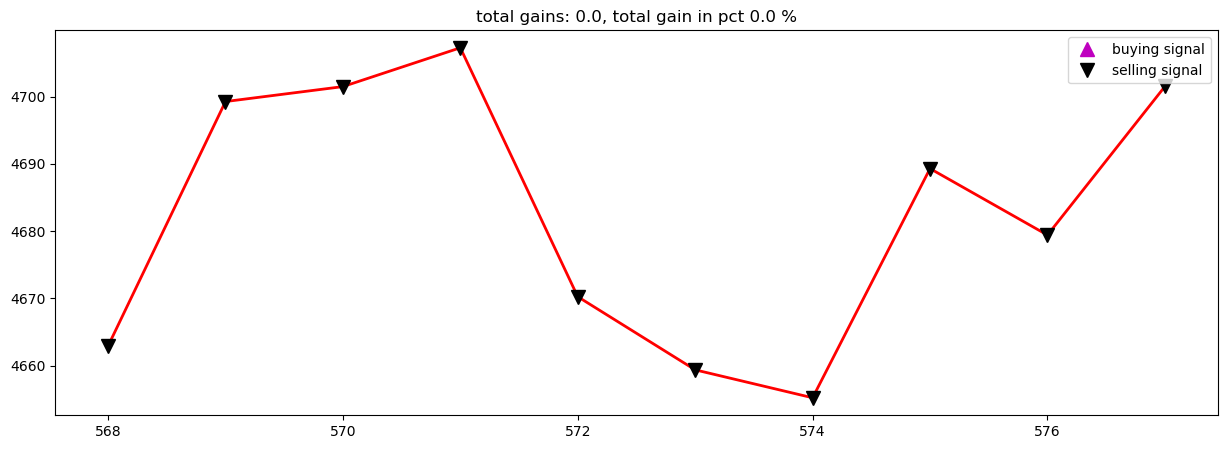

In [13]:
backtest_func(data[-len(y_test):],decision)

In [11]:

#np.savetxt("decision.csv",decision)

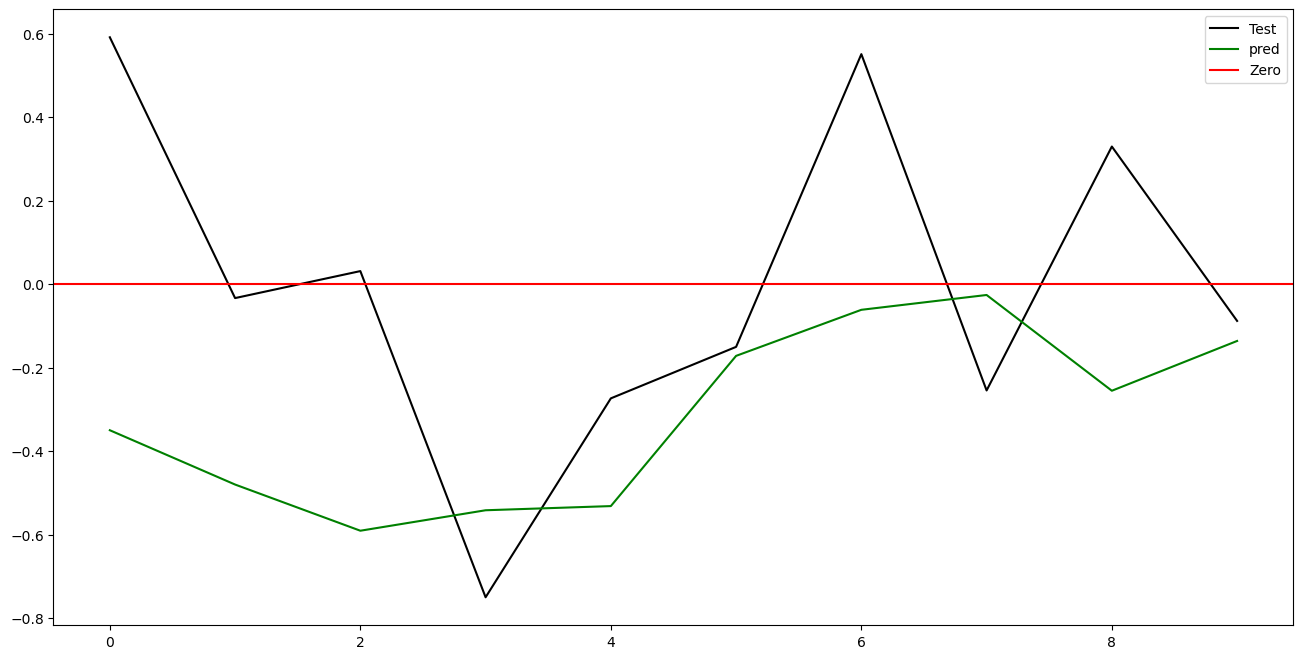

In [12]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.axhline(y = 0, color = 'r', linestyle = '-', label="Zero")
plt.legend()
plt.show()

In [13]:
# Evaluate results
sum((y_test>0)==(y_pred>0))/(len(y_test))

array([0.6])

In [52]:
# TO DO :- can you help me out to load the required unfortunatly it is showing problems 

#Load the model find the data type to load the model 
loaded_data = load_model('lstm_stock.h5')  # Which data to write here ? 
pred_x = loaded_data.predict_classes(X_train)

NameError: name 'load_model' is not defined

In [49]:
random_ind = np.random.choice(X_train.shape[0], 1000)
print(random_ind)
data_2 = X_train[random_ind[0:500]]
e = shap.DeepExplainer((loaded_data.layers[0].input, loaded_data.layers[-1].output),data_2)
test1 = X_train[random_ind[500:1000]]

[217 118 416 393 155 405 469 332 428 499 471 514   5 419 236  21  52 343
 479 308 426 167  55 526 523  64 280 297 431 379 266 191  19 119 320 255
  83 232  75 236 281 158 202  69 257  38   7  94 301 421 509 258 160 131
 387 387  44 447 365 341 100   2 247 431 415 466 317  77 155 509 533 191
  14 195  36 460 392 512 214 391 501 479 254 315 530 281 343 153  82 451
  33 203 519 451 446 260 144 127  62 426 246 381 407 297 469 438 288 234
 503  48 226 409 278 383 351 367 178 232 171  56 395 125 447 191 173 462
 295 216 150  91  25 188 125  18  93 221 321  26 449  68  39 252  10 221
 305 199 426 238 162 480  18 273 215  52 449 535 180  35 507  14  22 312
 345 455 177 295  13 270 176 532 461 349 410 111 236 369 187 373 421 112
 489 144  51 253 211  39   4 500 496 423 390 221 226  78 288 197 312 151
 400 185 106  86 154 534 186 209 243 320 243 522 469 504 195 153 391  59
 383 173 409 156 263 477 448  39 163 455  86 441 298 203 297 139 309 113
   1 417 145   7 225 175 172  61 510  96 268  51 31

NameError: name 'regressor' is not defined

In [58]:
shap_val = e.shap_values(test1)
shap_val = np.array(shap_val)
shap_val = np.reshape(shap_val,(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)

NameError: name 'e' is not defined

In [59]:
sum_0 = np.sum(shap_abs,axis=0)


NameError: name 'shap_abs' is not defined

In [55]:
#Sorting the filters if any , please add more Technical indicators and features if needed

features = ['Open','Close','Adj Close','RSI','EMAF','EMAM','EMAS','SMAF','SMAM','SMAS']
feature_position = [i for i, _ in enumerate(features)]
feature_position = feature_position
print(x_pos)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


NameError: name 'sum1' is not defined

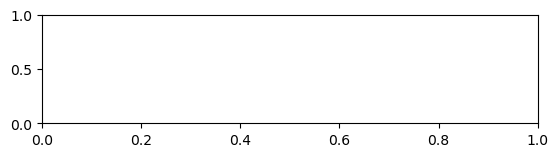

In [56]:
plt1 = plt.subplot(311)
plt1.barh(feature_position,sum1[1])
plt1.set_yticks(feature_position)
plt1.set_yticklabels(features)
plt1.set_title("Yesterday's features (time-step 2)")
plt2 = plt.subplot(312,sharex=plt1)
plt2.barh(feature_position,sum1[0])
plt2.set_yticks(feature_position)
plt2.set_yticklabels(features)
plt2.set_title("The day before yesterday's features(time-step 1)")
plt.tight_layout()
plt.show()